In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib as mpl
from ecbdata import ecbdata
from dateutil.relativedelta import relativedelta
from fredapi import Fred
import statsmodels.api as sm
import os
import scipy.optimize as spop
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ECBDFR.csv')

In [3]:
df.columns = ['Date','ECB_Dep_Rate']

In [8]:
df = df.iloc[:-1,:]

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df['ECB_Dep_Rate'] = df['ECB_Dep_Rate'].astype(float)

In [42]:
df.head(14)

,Date,ECB_Dep_Rate,relative_ir
0,2001-01-01,0.0375,0.028523
1,2001-02-01,0.0375,0.028523
2,2001-03-01,0.0375,0.028523
3,2001-04-01,0.0375,0.028523
4,2001-05-01,0.0350,0.026023
5,2001-06-01,0.0350,0.026023
6,2001-07-01,0.0350,0.026023
7,2001-08-01,0.0325,0.023523
8,2001-09-01,0.0275,0.018523
9,2001-10-01,0.0275,0.018523


In [14]:
df['ECB_Dep_Rate'] = df['ECB_Dep_Rate']/100

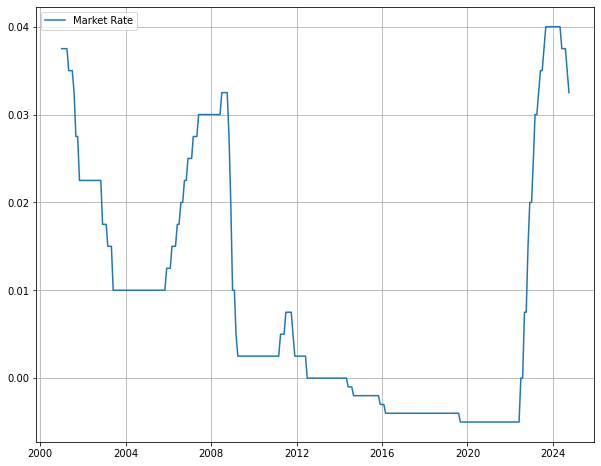

In [15]:
mpl.rcParams['figure.figsize'] = (10,8)

plt.plot(df['Date'], df['ECB_Dep_Rate'], label = 'Market Rate')
plt.legend()
plt.grid()
plt.show()

In [16]:
long_term_mean = df['ECB_Dep_Rate'].mean()
long_term_mean

0.008977272727272726

In [17]:
df['relative_ir'] = df['ECB_Dep_Rate'] - long_term_mean

In [18]:
import scipy.optimize as spop

In [19]:
df1 = pd.read_excel('EU Yield.xlsx')

In [22]:
np.log(0.993063)

-0.00696117284069545

In [20]:
df1

,time,type,int_rate,time_in_year,present_value
0,3,months,2.823568,0.25,0.993063
1,6,months,2.642200,0.50,0.987045
2,9,months,2.500397,0.75,0.981648
3,1,year,2.390358,1.00,0.976654
4,2,years,2.160392,2.00,0.958153
5,3,years,2.112264,3.00,0.939218
6,4,years,2.139577,4.00,0.918806
7,5,years,2.196207,5.00,0.897070
8,6,years,2.261722,6.00,0.874423
9,7,years,2.326957,7.00,0.851274


In [21]:
import scipy.integrate as integrate
from scipy import interpolate

In [28]:
def P0T(T):
    df1 = pd.read_excel('EU Yield.xlsx')
    ti = df1['time_in_year'].values
    pv = df1['present_value'].values
    interpolator = interpolate.splrep(ti, np.log(pv), s = 0.00001) 
    #log Linear interpolation
    #This method makes the curve smoother by reducing the sharpness of its angles
    expr = np.exp(interpolate.splev(T, interpolator, der = 0))
    
    return expr

In [29]:
def f0T(t):
    del_t = 0.001
    P0T_1 = P0T(t+del_t)
    P0T_2 = P0T(t-del_t)
    expr = - (np.log(P0T_1) - np.log(P0T_2)) / (2*del_t) #Approximation to differentiation formula
    return expr

In [30]:
def theta(t, lambd, sigma, dt):
    term_1 = f0T(t+dt)
    term_2 = f0T(t-dt)
    term_3 = f0T(t)
    term_4 = (sigma**2) / (2*lambd**2) * (1 - np.exp(-2*lambd*t))
    expr = (1/lambd)*(term_1 - term_2) / (2*dt) + term_3 + term_4
    return expr

In [31]:
f0T(0.0001)

0.016580993512113704

In [40]:
df_new = df.loc[12:275, :].reset_index(drop = True)

In [41]:
df_new.shape

(264, 3)

In [45]:
def Hull_White_Optimizer(param):
    lambd = param[0]
    sigma = param[1]
    
    r0 = 0.0225 #on Dec/2001
    
    #Calibrating on 2002-2023
    T_start = 1
    T_end = 23
    nsteps = 264 # 22 years * 12 months, as data is on monthly level
    #To create random normal variate mean = 0, std = 1
    Z = (np.random.normal(0.0,1.0,[nsteps]) - np.mean(np.random.normal(0.0,1.0,[nsteps]))) / np.std(np.random.normal(0.0,1.0,[nsteps]))
    W = np.zeros([nsteps+1])
    R = np.zeros([nsteps+1])
    
    R[0] = r0
    
    timeGrid = np.linspace(T_start, T_end, nsteps)
    dt = timeGrid[1] - timeGrid[0]
    for i, time in enumerate(timeGrid):
        W[i+1] = W[i] + np.power(dt,0.5) * Z[i]
        R[i+1] = R[i] + lambd * (theta(time,lambd,sigma,dt) - R[i])*dt + sigma*(W[i+1] - W[i])
        
    R_final = R[1:]
    df_new['Modeled_rate'] = R_final
    
    LL = np.sum(stats.norm.logpdf(df_new['ECB_Dep_Rate'], df_new['Modeled_rate'], sigma))
    
    neg_LL = -1 * LL
    
    return neg_LL

In [46]:
res = spop.minimize(Hull_White_Optimizer,[0.005, 0.001], method = 'Nelder-Mead')

In [47]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 32202.680690587535
             x: [ 4.805e-03  1.090e-03]
           nit: 156
          nfev: 400
 final_simplex: (array([[ 4.805e-03,  1.090e-03],
                       [ 4.805e-03,  1.090e-03],
                       [ 4.805e-03,  1.090e-03]]), array([ 3.220e+04,  8.214e+04,  9.919e+04]))

In [48]:
def Generate_Paths_HW(nsteps, lambd, sigma, T_start, T_end):
    r0 = 0.04 #On Dec 2023
    
    Z = (np.random.normal(0.0,1.0,[nsteps]) - np.mean(np.random.normal(0.0,1.0,[nsteps]))) / np.std(np.random.normal(0.0,1.0,[nsteps]))
    W = np.zeros([nsteps+1])
    R = np.zeros([nsteps+1])
    
    R[0] = r0
    
    timeGrid = np.linspace(T_start, T_end, nsteps)
    dt = timeGrid[1] - timeGrid[0]
    for i, time in enumerate(timeGrid):
        W[i+1] = W[i] + np.power(dt,0.5) * Z[i]
        R[i+1] = R[i] + lambd * (theta(time,lambd,sigma,dt) - R[i])*dt + sigma*(W[i+1] - W[i])
        
    return R

In [49]:
res.x

array([0.00480469, 0.00108984])

In [53]:
T_start = 24 #2024
T_end = 33 #2034
nsteps = 120 # 10 years * 12 months
lambd, sigma = res.x
r0 = 0.04
npaths = 100
rate = r0 * np.ones((npaths, nsteps+1))
rate = []

for i in range(1, npaths+1):
    rate.append(Generate_Paths_HW(nsteps,lambd,sigma,T_start,T_end))

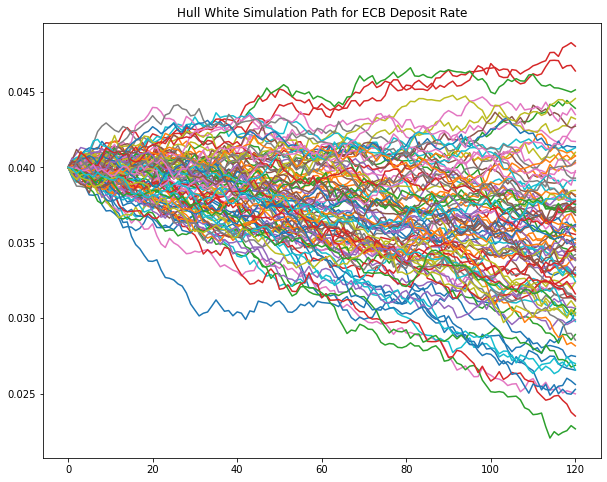

In [54]:
plt.figure(figsize=(10,8))

for i in range(len(rate)):
    plt.plot(rate[i], label = f'Path {i+1}')
plt.title('Hull White Simulation Path for ECB Deposit Rate')    
#plt.legend()
plt.show()